# Бинарная классификация изображений с помощью свёрточных нейронных сетей



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from typing import Type
from torch.optim import lr_scheduler
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,CrossEntropyLoss,Conv2d,MaxPool2d
import os
import sys
import random
import copy
import time
import shutil
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics
from pandas import DataFrame
import seaborn as sns
import pandas as pd
import numpy as np
import PIL
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn import preprocessing
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix





random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


Для того, чтобы отслеживать процесс обучения помимо визуализации в ноутбуке будем отслеживать ход эксперимента на платформе weights and biases. Скачаем библиотеку, введём логин и настроем config для интересующего эксперимента

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wandb login

wandb: Currently logged in as: andrew_mskv (ml_team_mskv). Use `wandb login --relogin` to force relogin


In [ ]:
import wandb

# start a new wandb run to track this script
run_resnet18 = wandb.init(
    # set the wandb project where this run will be logged
    project="SRAF Classification",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "dataset": "SRAF_DATASET_v2",
    "epochs": 20,
    "optimizer": 'Adam',
    "scheduler": 'StepLR'
    }
)

wandb: Currently logged in as: andrew_mskv (ml_team_mskv). Use `wandb login --relogin` to force relogin


Скачаем датасет из google-диска

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#первая версия датасета
#! unzip /content/drive/MyDrive/SRAF_dataset.zip

#вторая версия датасета
!unzip /content/drive/MyDrive/data/SRAF_dataset_v2.zip

 Создаём тренировочный и валидационный датасеты, задаём преобразования над изображениями, определяем классы. Из гистограммы одного из изображений были найдены величины **среднего и стандратного отклонения**. Поскольку изображения в датасете имеют очень похожую семантику, то было решено использовать эти величины при нормализации тензоров. Подробнее можно увидеть это в разделе **Image Normalization**.


In [ ]:
new_mean = torch.tensor([0.3898, 0.3898, 0.3898])
new_std = torch.tensor([0.1769, 0.1769, 0.1769])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(new_mean, new_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize(new_mean, new_std)
    ]),
}

data_dir = '/content/SRAF_dataset_v2'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class_names

['no_sraf_on_image', 'sraf_on_image']

In [ ]:
print(dataset_sizes)

{'train': 204, 'val': 52}


смотрим как выглядят данные

torch.Size([3, 244, 244])
Label: 0


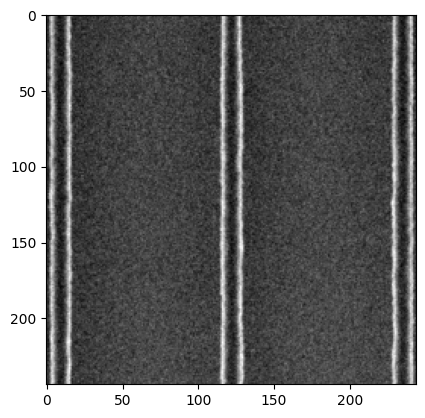

In [ ]:
img_1, label_1 = image_datasets['val'][13]
print(img_1.shape)
plt.imshow(img_1[2,:,:], cmap='gray')
print('Label:', label_1)
# Label '0' for NO_SRAF image,
# LAbel '1' for SRAF image

In [ ]:
#генерируем список из 10 рандомных чисел в отрезке от нуля до размера тренировочного датасета

random_numb = random.sample(range(0, dataset_sizes['train']), 10)
print(random_numb)

[98, 194, 107, 10, 66, 130, 124, 103, 200, 77]


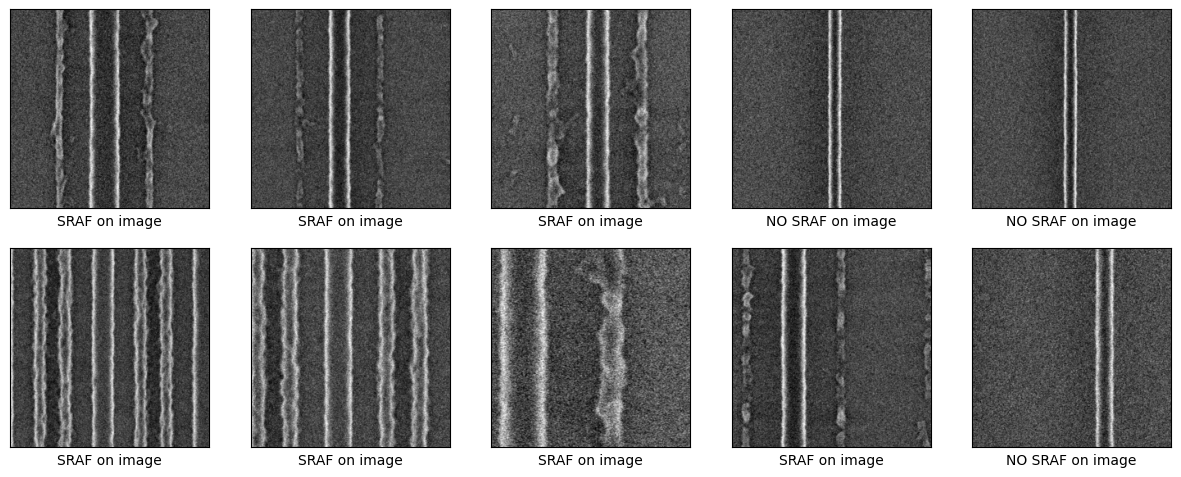

In [ ]:
# Посмотрим на 10 случайных изображений из тренировочного датасета
plt.figure(figsize=(15,15))
for i,j in enumerate(random_numb):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img, label = image_datasets['train'][j]
    plt.imshow(img[2,:,:], cmap='gray')

    if label == 0:
      plt.xlabel("NO SRAF on image")
    elif label == 1:
      plt.xlabel("SRAF on image")
    #plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Посмотрим на сбалансированность классов сбалансированность классов.
Наблюдается лёгкий дисбаланс.

Данные было не так уж просто собрать:)

<BarContainer object of 2 artists>

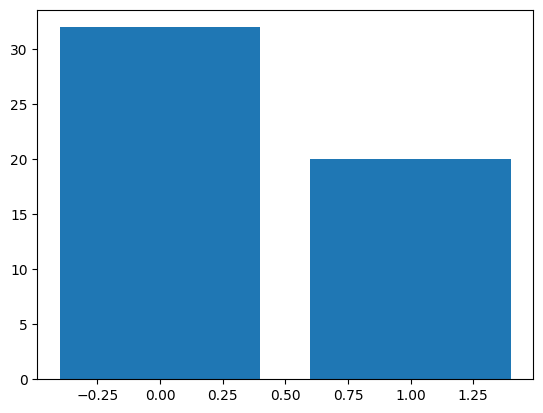

In [ ]:
stat=list(Counter(image_datasets['train'].targets).values())
plt.bar(np.arange(len(stat)),stat)

## Переходим к ML

универсальная функция обучения

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, wandb_run=run_alexnet):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch=0; best_acc = 0.0 #; best_loss = sys.maxsize
    hist_loss_train = []; hist_acc_train = []
    hist_loss_val = []; hist_acc_val = []

    for epoch in range(num_epochs):    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:    # Iterate over data.
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                #with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':     # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                hist_loss_train.append(epoch_loss)
                hist_acc_train.append(epoch_acc.cpu().item())
            else:
                hist_loss_val.append(epoch_loss)
                hist_acc_val.append(epoch_acc.cpu().item())
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc.item()
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
        clear_output(True)

        #logging with weights and biases
        wandb.log({'epoch': epoch, 'train_loss': round(hist_loss_train[-1], 2),
                   'train_acc': hist_acc_train[-1], 'val_loss': round(hist_loss_val[-1], 2),
                   'vall_acc': hist_acc_val[-1]})


        plt.plot(hist_loss_train,label='hist_loss_train ({})'.format(round(hist_loss_train[-1],2)))
        plt.plot(hist_loss_val,label='hist_loss_val ({})'.format(round(hist_loss_val[-1],2)))
        plt.legend(framealpha=1, frameon=True);
        plt.title('Loss (epoch {}/{})'.format(epoch,num_epochs))
        plt.grid(linestyle='dashed')
        plt.show()
    model.eval()
    plt.plot(hist_acc_train,label='hist_acc_train')
    plt.plot(hist_acc_val,label='hist_acc_val')
    plt.legend(framealpha=1, frameon=True);
    plt.title('Acc')
    plt.grid(linestyle='dashed')
    plt.show()
    model.load_state_dict(best_model_wts)     # load best model weights

    print(f"Best validation accuracy:{round(best_acc,3)}")
    print(f"Best validation loss:{round(best_loss,2)}")
    print(f"Best validation epoch:{round(best_epoch)}")

    wandb_run.finish()
    return model,best_acc

In [ ]:
def predict(model, test_loader):
    model.eval()
    logits=[]
    tr_lab = []

    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        logits.append(list(predicted.cpu().numpy()))
        tr_lab.append(list(labels.cpu().numpy()))
    return logits, tr_lab


In [ ]:
def visualize_model(model, num_images = 6):
  images_so_far = 0
  fig = plt.figure(figsize=(14,10))

  model.eval()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      pred_probs = torch.softmax(outputs.data, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        plt.subplot(2,3,images_so_far)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        plt.imshow(inputs.cpu().data[j][2,:,:], cmap='gray') ## or we can write: plt.imshow(inputs.data[j].permute(1,2,0), cmap='gray')
        plt.xlabel(f"Predicted label:{class_names[preds[j]]}\n Probability:{pred_probs[j].max():.2f} ", fontsize=12)

        if images_so_far == num_images:
          return





 В силу небольшого размера датасета оптимальнее всего не обучать сеть с нуля, а взять предобученную нейросеть и дообучить её на имеющемся датасете. Такая техника называется Transfer Learning или перенос обучения. В ячейке ниже представлено как можно настроить различные архитектуры под бинарную классификацию. В ноутбуке представлен результат обучения AlexNet для данного датасета. Также в ноутбуке присутствуют разделы, где задаются такие модели как VGG16, ResNet18.

In [ ]:
# model_ft = models.alexnet(pretrained=True) #  for AlexNet
model_ft = models.resnet18(pretrained=True)  #  for ResNET 18
# model_ft = models.resnet50(pretrained=True)  #  for ResNET 50
# model_ft = models.densenet121(pretrained=True)  #  for densenet
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features   #  for ResNET
model_ft.fc = nn.Linear(num_ftrs, len(ls))    #  for ResNET
# num_ftrs = model_ft.classifier.in_features    #  for densenet
# model_ft.classifier = nn.Linear(num_ftrs, len(ls))    #  for densenet
# model_ft.classifier =nn.Linear(9216, len(ls))   #  for AlexNet

Задаем гиперпараметры

In [ ]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Обучаем

In [ ]:
model_ft,best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

# AlexNet


In [ ]:
#!wandb login

import wandb

# start a new wandb run to track this script
run_alexnet = wandb.init(
    # set the wandb project where this run will be logged
    project="SRAF Classification",
    #the above command allows runnig multiple runs from one script
    reinit =True,
    settings=wandb.Settings(start_method="fork"),

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": 'AlexNet',
    "dataset": "SRAF_DATASET_v2",
    "epochs": 20,
    "optimizer": 'Adam',
    "scheduler": 'StepLR',
    "transforms": 'Changed Normalization'
    }
)

wandb: Currently logged in as: andrew_mskv (ml_team_mskv). Use `wandb login --relogin` to force relogin


In [ ]:
model_alexnet = models.alexnet(pretrained=True) #  for AlexNet

for param in model_alexnet.parameters():
    param.requires_grad = False

#simple classification layer
model_alexnet.classifier = nn.Linear(9216, 2)

# model_alexnet.classifier = nn.Sequential(
#     nn.Linear(9216, 512),
#     nn.Linear(512, 128),
#     nn.Linear(128, 32),
#     nn.Linear(32, 2)
# )

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_alexnet = model_alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_alexnet = optim.Adam(model_alexnet.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_alexnet, step_size=7, gamma=0.1)

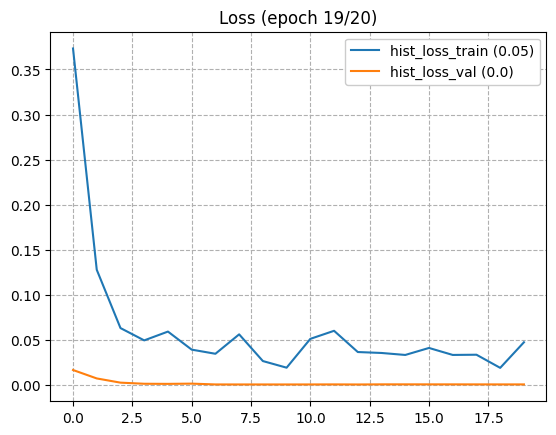

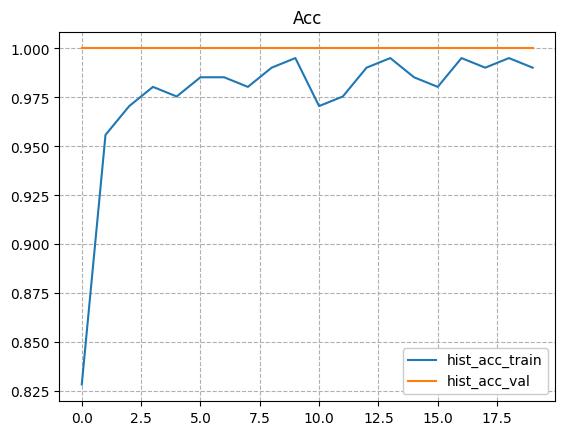

Best validation accuracy:1.0
Best validation loss:0.02
Best validation epoch:0


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▆▇▇▇██▇██▇▇███▇████
train_loss,█▃▂▂▂▁▁▂▁▁▂▂▁▁▁▁▁▁▁▂
val_loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
vall_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,19
train_acc,0.9902
train_loss,0.05
val_loss,0.0
vall_acc,1.0


In [ ]:
model_alexnet,best_acc_alexnet = train_model(model_alexnet, criterion, optimizer_alexnet, exp_lr_scheduler, 20, wandb_run = run_alexnet )

In [ ]:
best_acc_alexnet

1.0

[[ 81   8]
 [  3 112]]


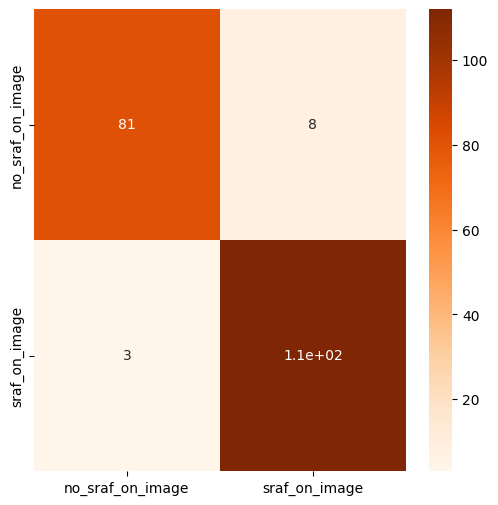

In [ ]:
true_labels=[]
pred_labels=[]
for inputs, labels in dataloaders['train']:
  pred = model_alexnet(inputs.to(device))
  _, pred = torch.max(pred, 1)
  labels.to(torch.device("cpu"))
  pred.to(torch.device("cpu"))
  true_labels.extend(labels.tolist());
  pred_labels.extend(pred.tolist());
cm=metrics.confusion_matrix(true_labels,pred_labels)
print(cm)
fig, ax = plt.subplots(figsize=(6,6))
df_cm = DataFrame(cm, index=class_names, columns=class_names)
ax = sns.heatmap(df_cm, cmap='Oranges', annot=True,ax=ax)


In [ ]:
visualize_model(model_alexnet)

Подгрузим тестовый датасет и посмотрим на предсказания модели:

In [ ]:
! unzip /content/SRAF_TEST.zip

Predict class: sraf_on_image


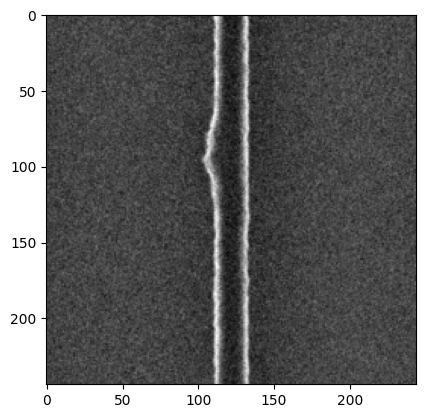

In [ ]:
# img=PIL.Image.open('my_hand_v.png').convert('RGB')
img_path = '/content/SRAF_TEST/test_images/S04_M0031-01MS.tif'
img=PIL.Image.open(img_path).convert('RGB')

inputs=data_transforms['val'](img)
#plt.imshow(inputs.numpy()[2,:,:]) #.transpose((1, 2, 0)))
plt.imshow(inputs[2,:,:], cmap='gray')
inp = inputs[None,:].to(device)
outp = model_alexnet(inp)
_, preds = torch.max(outp, 1)
print("Predict class: {}".format(class_names[int(preds)]))

In [ ]:
torch.save(model_alexnet.state_dict(), 'AlexNet_new_dataset.pth')

# Собственная реализация ResNET 18

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride = 1, expansion = 1, downsample = None):
        super(BasicBlock, self).__init__()
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d( in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d( out_ch, out_ch*self.expansion, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch*self.expansion)
    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x)))))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

In [ ]:
class MyResNet(nn.Module):
    def __init__(self, img_channels=3, num_layers=18, block=Type[BasicBlock],
        num_classes  = 1000):
        super(MyResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock`
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1
        self.in_ch = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=self.in_ch,
            kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_ch)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
    def _make_layer(self, block, out_ch, blocks, stride = 1):
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(self.in_ch, out_ch*self.expansion, kernel_size=1,
                    stride=stride, bias=False),
                nn.BatchNorm2d(out_ch * self.expansion),
            )
        layers = []
        layers.append(block(self.in_ch, out_ch, stride, self.expansion, downsample))
        self.in_ch = out_ch * self.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_ch, out_ch, expansion=self.expansion))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        # The spatial dimension of the final layer's feature
        # map should be (7, 7) for all ResNets.
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Создадим артефакты для обучения

In [ ]:
myResNet=MyResNet(3,18, BasicBlock,len(ls)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(myResNet.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Обучим собственную модель ResNet18

# VGG 16 model


In [ ]:
model_vgg = models.vgg16_bn(pretrained=True)
child_counter = 0
for child in model_vgg.children():
   print(" child", child_counter, "is:")
   print(child)
   child_counter += 1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 child 0 is:
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1),

In [ ]:
model_vgg._modules

OrderedDict([('features',
              Sequential(
                (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU(inplace=True)
                (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (5): ReLU(inplace=True)
                (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
                (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (9): ReLU(inplace=True)
                (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
print("Распечатаем последний слой, отвечающий за классификацию:\n")

print(model_vgg.classifier[6],'\n')

print("Видим, что количество выходных классов - 1000. Нам нужно всего 2")

Распечатаем последний слой, отвечающий за классификацию:

Linear(in_features=4096, out_features=1000, bias=True) 

Видим, что количество выходных классов - 1000. Нам нужно всего 2


Также мы можем обратиться отдельным блокам или слоям vgg при помощи следующих команд:

In [ ]:
print("Обращение ко второму ребёнку:\n ")
print(list(model_vgg.children())[2],'\n')
print("Обращение к отдельному слою из второго ребёнка:\n")
print(list(model_vgg.children())[2][6])

Обращение ко второму ребёнку:
 
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
) 

Обращение к отдельному слою из второго ребёнка:

Linear(in_features=4096, out_features=2, bias=True)


In [ ]:
for param in model_vgg.features.parameters():
  param.requires_grad = False

num_features = model_vgg.classifier[6].in_features
features = list(model_vgg.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 2)])
model_vgg.classifier = nn.Sequential(*features)
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
model_vgg = model_vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(model_vgg.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)

In [ ]:
for param in model_vgg.parameters():
    print(param.requires_grad,end=" ")

False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False True True True True True True 

In [ ]:
model_vgg,best_acc = train_model(model_vgg, criterion, optimizer_vgg, exp_lr_scheduler, 20)

# ResNet 18 model


In [ ]:
import wandb

# start a new wandb run to track this script
run_resnet18 = wandb.init(
    # set the wandb project where this run will be logged
    project="SRAF Classification",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": 'ResNet18',
    "dataset": "SRAF_DATASET_v1",
    "epochs": 20,
    "optimizer": 'Adam',
    "scheduler": 'StepLR'
    }
)

wandb: Currently logged in as: andrew_mskv (ml_team_mskv). Use `wandb login --relogin` to force relogin


In [ ]:
model_resnet18 = models.resnet18(pretrained=True)  #  for ResNET 18

for param in model_resnet18.parameters():
    param.requires_grad = False
num_ftrs = model_resnet18.fc.in_features   #  for ResNET
model_resnet18.fc = nn.Linear(num_ftrs, 2)    #  for ResNET
# num_ftrs = model_ft.classifier.in_features    #  for densenet
# model_ft.classifier = nn.Linear(num_ftrs, len(ls))    #  for densenet
# model_ft.classifier =nn.Linear(9216, len(ls))   #  for AlexNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


In [ ]:
model_resnet18 = model_resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model_resnet18.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)

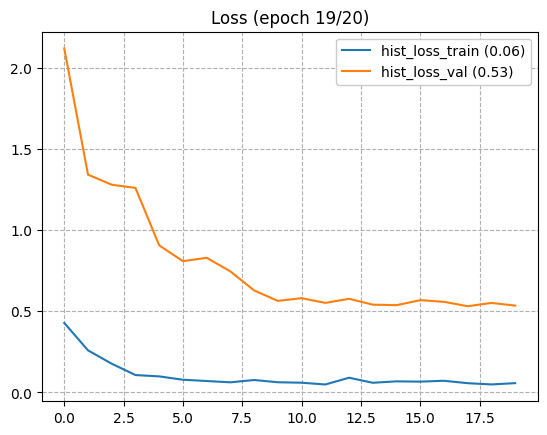

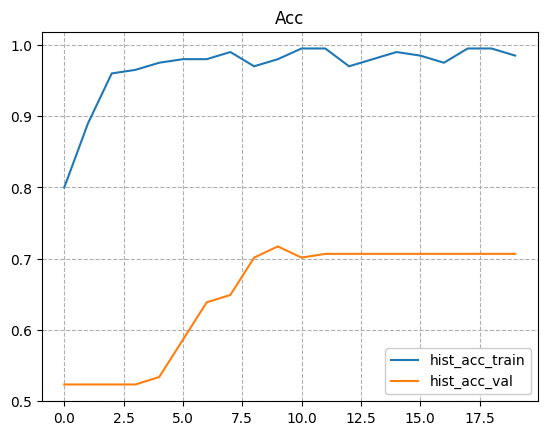

Best validation accuracy:0.717
Best validation loss:0.56
Best validation epoch:9


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▄▇▇▇▇▇█▇▇██▇▇██▇███
train_loss,█▅▃▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
vall_acc,▁▁▁▁▁▃▅▆▇█▇█████████
epoch,19
train_acc,0.985
train_loss,0.06
val_loss,0.53
vall_acc,0.70681


In [ ]:
model_resnet18,best_acc_resnet = train_model(model_resnet18, criterion, optimizer_resnet, exp_lr_scheduler, 20)

In [ ]:
run_resnet18.finish()

In [ ]:
best_acc_resnet

0.7172774869109948

[[ 37  54]
 [  0 100]]


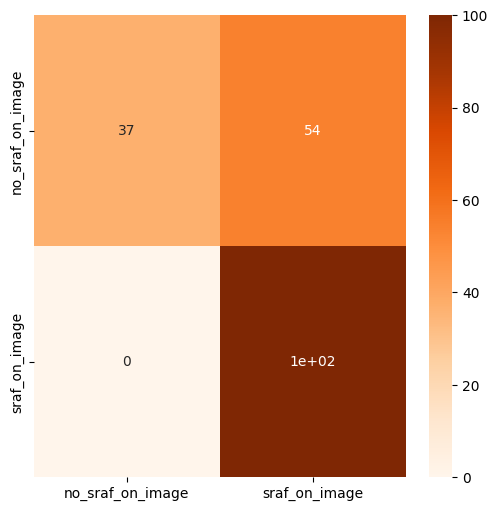

In [ ]:
true_labels=[]
pred_labels=[]
for inputs, labels in dataloaders['val']:
  pred = model_resnet18(inputs.to(device))
  _, pred = torch.max(pred, 1)
  labels.to(torch.device("cpu"))
  pred.to(torch.device("cpu"))
  true_labels.extend(labels.tolist());
  pred_labels.extend(pred.tolist());
cm=metrics.confusion_matrix(true_labels,pred_labels)
print(cm)
fig, ax = plt.subplots(figsize=(6,6))
df_cm = DataFrame(cm, index=class_names, columns=class_names)
ax = sns.heatmap(df_cm, cmap='Oranges', annot=True,ax=ax)


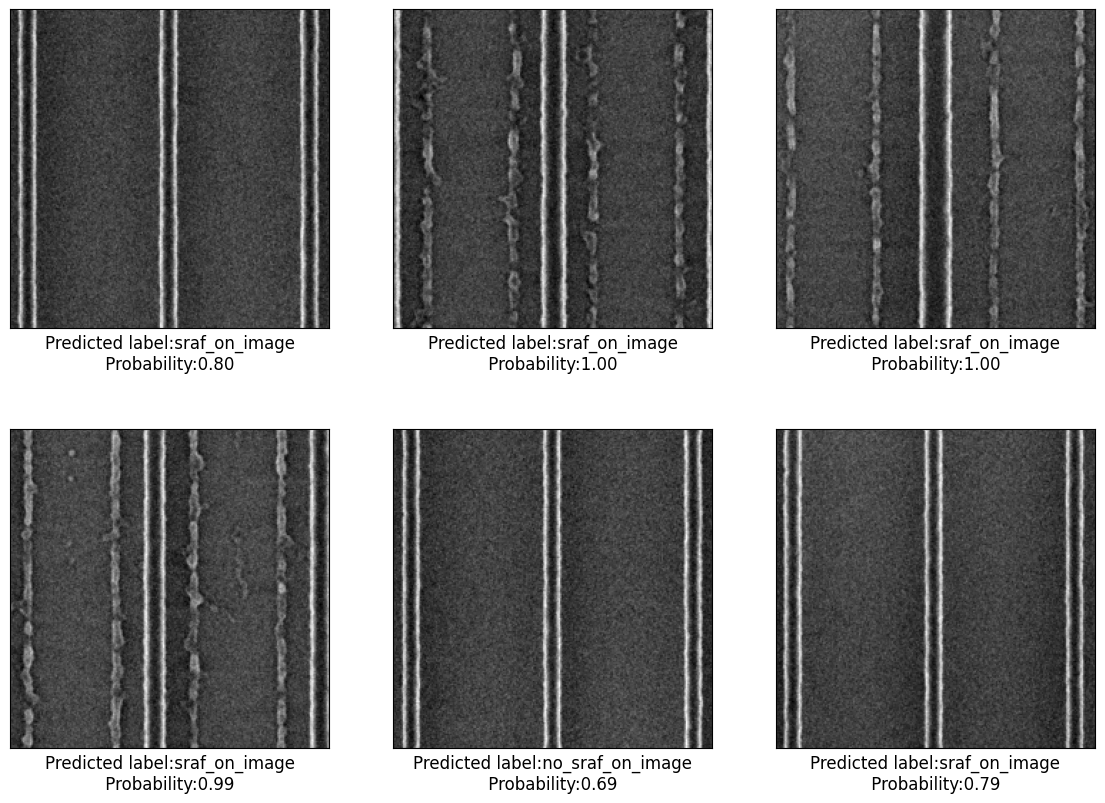

In [ ]:
visualize_model(model_resnet18)

In [ ]:
y_hat, tr_lab = predict(model_resnet18, dataloaders['val'])
true_labels= [item for sublist in tr_lab for item in sublist]
mylist_n = [j for i in y_hat for j in i]

le = preprocessing.LabelEncoder()
le.fit(['NO SRAF on image', 'SRAF on image'])
true_labels = list(le.inverse_transform(true_labels))
final_pred = list(le.inverse_transform(mylist_n))

In [ ]:
print(classification_report(true_labels, final_pred))


                  precision    recall  f1-score   support

NO SRAF on image       1.00      0.41      0.58        91
   SRAF on image       0.65      1.00      0.79       100

        accuracy                           0.72       191
       macro avg       0.82      0.70      0.68       191
    weighted avg       0.82      0.72      0.69       191



<Axes: >

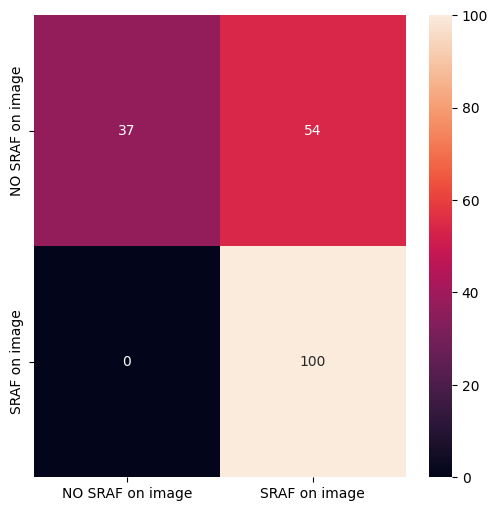

In [ ]:
confusion_matrix(true_labels, final_pred, labels=['NO SRAF on image', 'SRAF on image'] )
confusion_matr = confusion_matrix(true_labels, final_pred, labels=['NO SRAF on image', 'SRAF on image'] )
conf_matr = pd.DataFrame(confusion_matr, index = ['NO SRAF on image', 'SRAF on image'], columns=['NO SRAF on image', 'SRAF on image'])
plt.figure(figsize=(6,6))

sns.heatmap(conf_matr, annot=True, fmt='g', cmap="rocket")

# Image Normalization



Text(0.5, 1.0, 'distribution of pixels')

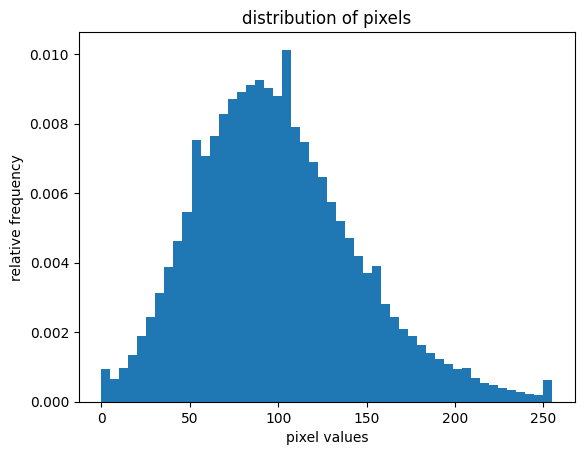

In [ ]:
from PIL import Image
# load the image
img_path = '/content/SRAF_dataset/train/sraf_on_image/E04_M0107-01MS.tif'
img = Image.open(img_path).convert('RGB')

# convert PIL image to numpy array
img_np = np.array(img)

# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")


mean and std before normalize
Mean of the image tensor([0.3898, 0.3898, 0.3898])
Std of the image tensor([0.1769, 0.1769, 0.1769])


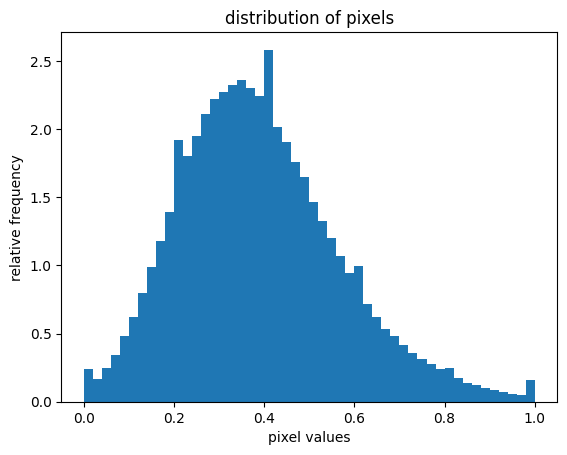

In [ ]:


# define custom transform function
# transform = transforms.Compose([
# 	transforms.ToTensor()
# ])

single_transform = transforms.ToTensor()
img_tr = single_transform(img)

# Convert tensor image to numpy array
img_np = np.array(img_tr)

# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

new_mean, new_std = img_tr.mean([1,2]), img_tr.std([1,2])
print("mean and std before normalize")
print('Mean of the image', new_mean)
print('Std of the image', new_std)


In [ ]:
img_tr.shape

torch.Size([3, 1024, 1024])

In [ ]:
# mean = torch.tensor([0.485, 0.485, 0.485])
# std = torch.tensor([0.229, 0.229, 0.229])


Text(0.5, 1.0, 'distribution of pixels')

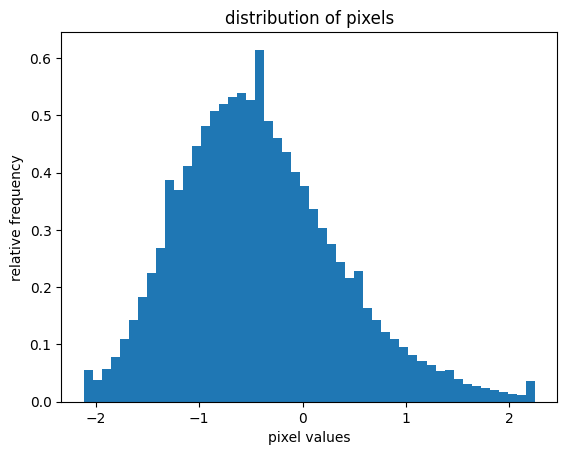

In [ ]:
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

img_normalized = transform_norm(img)

img_np = np.array(img_normalized)
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel('pixel values')
plt.ylabel("relative frequency")
plt.title('distribution of pixels')

([], [])

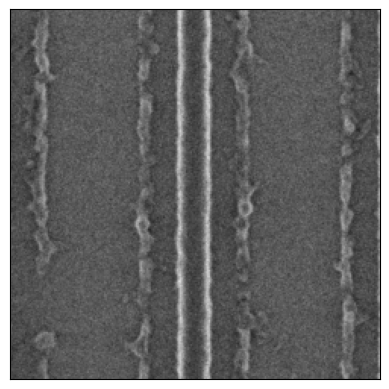

In [ ]:
#img_normalized = transform_norm(img)

# convert this image to numpy array
img_normalized = np.array(img_1)

# transpose from shape of (3,,) to shape of (,,3)
img_normalized = img_normalized.transpose(1, 2, 0)

# display the normalized image
plt.imshow(img_normalized)
plt.xticks([])
plt.yticks([])

In [1]:
print('what a simple image out there')

what a simple image out there
